In [1]:
!pip install --upgrade scipy==1.4.1 # Need a more recent version for this notebook

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.
  Using cached scipy-1.4.1-cp35-cp35m-manylinux1_x86_64.whl (26.0 MB)


In [2]:
import os
import sys
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import seaborn as sns
import scipy


from sklearn.linear_model import LassoLarsCV


sys.path.append('../common')
import data_io_utils
import paths
import constants
import utils
import plot_style_utils

sys.path.append('../A006_simulated_annealing/')
import A006_common
from unirep import babbler1900 as babbler

sys.path.append('../A003_policy_optimization/')
import A003_common

import A008_common

%reload_ext autoreload
%autoreload 2

In [3]:
# Generated in mlpe-gfp-pilot repository
lfe_data_file = os.path.join(data_io_utils.S3_DATA_ROOT, 'chip_1', 
        'A052e_BLAC_log_fold_enrichment.csv')

data_io_utils.sync_s3_path_to_local(lfe_data_file, is_single_file=True)

df = pd.read_csv(lfe_data_file)

q = df['id'].apply(lambda s: pd.Series(A008_common.split_seq_id_into_features(s)))
df = df.merge(q, left_index=True, right_index=True)

display(df.head())
print(df.columns)

,lfe_250,lfe_1000,lfe_2500,lfe_5000,rep1_250,rep1_1000,rep1_2500,rep1_5000,rep2_250,rep2_1000,...,ligated_gene,ligated_gene_translated,n_mut_rel_wt,oligo_len,model,ntrain,rep,rep_hash,seq_traj_idx,special_case
0,-1.003346,-2.423684,-2.469612,-2.194874,-1.003346,-2.125728,-2.255074,-2.194874,-0.734210,-2.423684,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,ET_Random_Init_1,96,3,33bfb65e,seq_idx_2563_2629,
1,-1.207588,-2.195691,-2.400481,-2.088745,-1.207588,-2.195691,-1.847915,-2.088745,-1.113712,-1.509455,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,OneHot,24,2,1d0c4863,seq_idx_2053_3311,
2,-1.449553,-1.769109,-2.618223,-2.315377,-1.079944,-1.769109,-1.773516,-2.315377,-1.449553,-1.530902,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,OneHot,96,0,2277bff5,seq_idx_2514_3406,
3,-1.268493,-2.465868,-2.812826,-2.476037,-1.027188,-2.406891,-2.536237,-2.476037,-1.268493,-2.465868,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,OneHot,96,3,108b3ec7,seq_idx_1878_128,
4,-1.417045,-1.590053,-2.227124,-2.166924,-1.417045,-1.428771,-2.227124,-2.166924,-1.011380,-1.590053,...,ATGAGTATTCAACATTTCCGTGTCGCCCTTATTCCCTTTTTTGCGG...,MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIE...,7.0,293.0,ET_Random_Init_1,96,3,33bfb65e,seq_idx_2894_1066,


Index(['lfe_250', 'lfe_1000', 'lfe_2500', 'lfe_5000', 'rep1_250', 'rep1_1000',
       'rep1_2500', 'rep1_5000', 'rep2_250', 'rep2_1000', 'rep2_2500',
       'rep2_5000', 'lib_region', 'id', 'DE_Chip_1_BLAC_NGS_01',
       'DE_Chip_1_BLAC_NGS_02', 'DE_Chip_1_BLAC_NGS_03',
       'DE_Chip_1_BLAC_NGS_04', 'DE_Chip_1_BLAC_NGS_05',
       'DE_Chip_1_BLAC_NGS_06', 'DE_Chip_1_BLAC_NGS_07',
       'DE_Chip_1_BLAC_NGS_08', 'DE_Chip_1_BLAC_NGS_09',
       'DE_Chip_1_BLAC_NGS_10', 'seq_idx', 'trajectory_idx',
       'predicted_fitness', 'ensemble_predicted_fitness', 'seq', 'protein',
       'pred_score', 'lib_aa_seq', 'constant_where_expected',
       'successfully_clones', 'error_message', 'dna_to_order', 'ligated_gene',
       'ligated_gene_translated', 'n_mut_rel_wt', 'oligo_len', 'model',
       'ntrain', 'rep', 'rep_hash', 'seq_traj_idx', 'special_case'],
      dtype='object')


In [4]:
WT_IDX = np.argwhere(df['seq'] == constants.BETA_LAC_AA_SEQ).reshape(-1)[0]
AB_CONCS = [250, 1000, 2500]

In [5]:
def find_non_functional_population_mean_and_std(x): # From A010a_explore
    mu = np.median(x)
    std = scipy.stats.median_absolute_deviation(x)
    
    return mu, std

# Copied from A008d with modifications
def jitter_by_rep(df_sub, qfunc_col, ax=None):
    wt_qfunc = df[qfunc_col].iloc[WT_IDX]
    
    sns.stripplot(x="rep", y=qfunc_col, data=df_sub, color='k', size=4, ax=ax, jitter=0.15)
    ax.axhline(wt_qfunc, color=plot_style_utils.CAT_PALETTE[0], linewidth=3)
    ax.set_xticklabels(list('ABCDE'))

    
def jitter_plots_for_all_models_and_reps_at_ntrain(ntrain, qfunc_col,
        models=None, use_large_mut=False):
    
    if models is None:
        models = ['OneHot', 'ET_Random_Init_1', 'ET_Global_Init_1']
        
    wt_qfunc = df[qfunc_col].iloc[WT_IDX]
    
    plt.rcParams.update({'mathtext.default':  'regular' })
    fig, axes = plt.subplots(1,len(models), sharey=True, figsize=(11*(len(models)/4)*(3/4),5*2/3))
    
    nf_mu, nf_std = find_non_functional_population_mean_and_std(
        df[df['ntrain'] == ntrain][qfunc_col])
    
    ylims = []
    for i,model in enumerate(models):
        if use_large_mut:
            mask = np.logical_and(
                np.logical_and(df['model'] == model, df['ntrain'] == ntrain), 
                df['special_case'] == 'LargeMut'
            )
        else:
            mask = np.logical_and(
                np.logical_and(df['model'] == model, df['ntrain'] == ntrain), 
                df['special_case'] != 'LargeMut'
            )

        df_sub = df[mask]
        hit_rate = 100*np.sum(df_sub[qfunc_col] > wt_qfunc)/df_sub.shape[0]
        
        plot_style_utils.prettify_ax(axes[i])
        jitter_by_rep(df_sub, qfunc_col, ax=axes[i])

        #plot_title = model + '\n' + 'Avg. Hit Rate = %2.1f%%'%hit_rate
        #axes[i].title.set_text(plot_title)
        plot_title = '%2.1f%%'%hit_rate
        axes[i].title.set_text(plot_title)
        
        ylims.append(axes[i].get_ylim())
        axes[i].axhspan(-4,nf_mu+2*nf_std,color=[0.8, 0.8, 0.8], alpha=0.5) ## HARD CODED
        
        axes[i].set_ylabel('')
        axes[i].set_xlabel('')
        axes[i].grid(True)
        axes[i].set_yticks(np.arange(-4,3).astype(int))
        
    ylim_final = np.max(np.vstack(ylims),axis=0)
    for ax in axes:
        ax.set_ylim(ylim_final)

    return fig, axes

In [6]:
plot_style_utils.set_pub_plot_context()

## Biological reproducibility (Supp Fig. 10)

In [7]:
def draw_xeqy(ax, color):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    minv = min(xlim[0], ylim[0])
    maxv = max(xlim[1], ylim[1])
    
    ax.plot([minv, maxv], [minv, maxv], '-', color=color)
    ax.set_xlim([minv, maxv])
    ax.set_ylim([minv, maxv])

0.9229464729599739
0.7864473387591735
0.7389883624743103


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


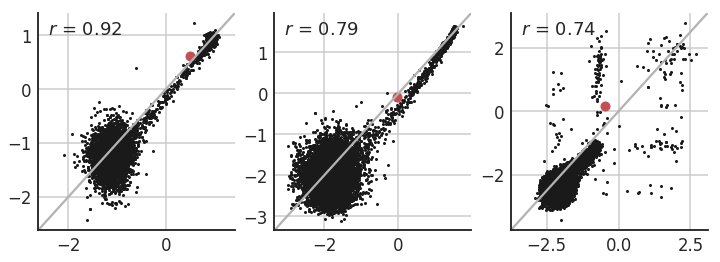

In [8]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

for i in range(len(AB_CONCS)):

    x = np.array(df['rep1_' + str(AB_CONCS[i])])
    y = np.array(df['rep2_' + str(AB_CONCS[i])])
        
    plot_style_utils.prettify_ax(axes[i])
    axes[i].plot(x, y, '.k', markersize=4)
    axes[i].plot(x[WT_IDX], y[WT_IDX], 'or')
    
    axes[i].text(0.05, 0.9, '$\it{r}$ = %0.2f'%np.corrcoef(x,y)[0,1], transform=axes[i].transAxes)
    print(np.corrcoef(x,y)[0,1])
    draw_xeqy(axes[i], color=[0.7, 0.7, 0.7])
    
    axes[i].grid('on')
    
    
plt.show()

plot_style_utils.save_for_pub(fig=fig, path='figures/BLAC_bioreproduciblity')

## Performance at N=24 (Supp Fig 11)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


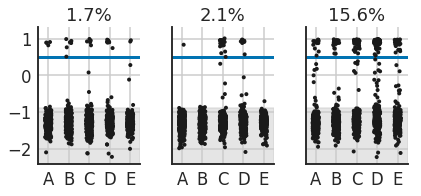

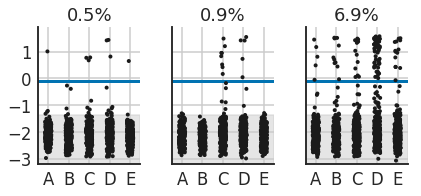

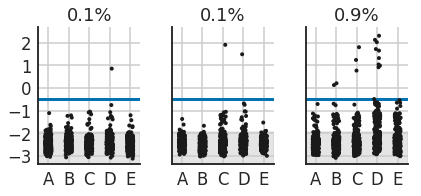

In [9]:
for ab in AB_CONCS:
    fig, axes = jitter_plots_for_all_models_and_reps_at_ntrain(
            ntrain=24, qfunc_col='lfe_'+str(ab))
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.suptitle('%s ug/mL' % str(ab), fontsize=16)
    plt.show()
    
    plot_style_utils.save_for_pub(fig=fig, path='figures/BLAC_N24_abconc-%s'%str(ab))

## Performance at N=96 (Fig 3b)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


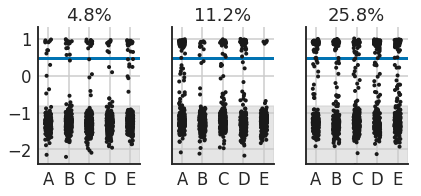

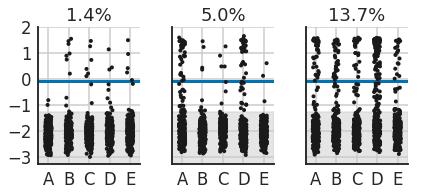

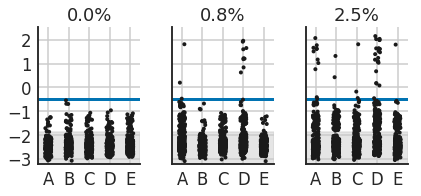

In [10]:
for ab in AB_CONCS:
    fig, axes = jitter_plots_for_all_models_and_reps_at_ntrain(
            ntrain=96, qfunc_col='lfe_'+str(ab))
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    plot_style_utils.save_for_pub(fig=fig, path='figures/BLAC_N96_abconc-%s'%str(ab))